# Joints2Sign: Sign Language Recognition through Hand Pose Estimation

Pastore Giuseppe 257649@studenti.polito.it  
Loparco Enrico enrico.loparco@studenti.polito.it

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, Dataset
from torch.backends import cudnn
import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torch.autograd import Function
import torch.nn.functional as F
from torch import autograd

import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import json
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import math
from copy import copy
import random
import cv2
from google.colab.patches import cv2_imshow

## Models

### Joints2Sign

In [0]:
def to_polar(x, y, x_wrist, y_wrist, wrist_avg, width=256, height=256):
    # if the wrist is missing (= dummy value (0,0)) use average calculated over the dataset
    x_wrist[(x_wrist==0) & (y_wrist==0)] = wrist_avg['x']
    y_wrist[(x_wrist==0) & (y_wrist==0)] = wrist_avg['y']

    x_wrist_rescaled = x_wrist.unsqueeze_(-1).expand(x.shape[0], x.shape[1])
    y_wrist_rescaled = y_wrist.unsqueeze_(-1).expand(y.shape[0], y.shape[1])
    x = x.sub(x_wrist_rescaled)
    y = y.sub(y_wrist_rescaled)
    
    r = torch.sqrt((x.abs()**2 + y.abs()**2 + 10e-9).double())/ (math.sqrt(width**2 + height**2))
    r[:, 0] = 0 # set wrist to (0,0), seeded because of the +10e-9 in the line above
    theta = torch.atan(y / (x + 10e-9)) / (2*math.pi)
    return r.float(),theta.float()

In [0]:
class Joints2Sign(nn.Module):
    def __init__(self, wrist_avg, num_joints=21, num_classes=22):
        super(Joints2Sign, self).__init__()        
        self.num_joints = num_joints

        # DeepPose (w/o dropout)
        self.conv1 = nn.Conv2d(3, 96, 11, stride=4, padding=1)
        self.conv2 = nn.Conv2d(96, 256, 5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(256, 384, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, 3, stride=1, padding=1)
        self.fc6 = nn.Linear(256*6*6, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, num_joints*2)

        # batch normalization
        self.bn = nn.BatchNorm1d(num_features=num_joints*2)

        # AlexNet-based classifier
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(21*2, 21*2),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(21*2, 30),
            nn.ReLU(inplace=True),
            nn.Linear(30, num_classes),
        )

    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pool2d(h, 3, stride=2)
        h = F.local_response_norm(h, 96)

        h = F.relu(self.conv2(h))
        h = F.max_pool2d(h, 3, stride=2)
        h = F.local_response_norm(h, 256)

        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.relu(self.conv5(h))
        h = F.max_pool2d(h, 3, stride=2)
       
        h = h.view(h.size(0), -1)
        h = F.relu(self.fc6(h))
        h = F.relu(self.fc7(h))
        h = self.fc8(h)

        joints = h.view(-1, self.num_joints, 2)
        
        # polar coordinate conversion
        r, theta  = to_polar(joints[:,:,0], joints[:,:,1], joints[:,0,0], joints[:,0,1], wrist_avg)
        x = torch.stack([r, theta], -1)
        x = x.view(h.size(0), -1)
        x = self.bn(x)    
        
        label = self.classifier(x)
        return joints, label

### ISL (italian sign language) 

Model used by the authors of the dataset

In [0]:
class ISL(nn.Module):
    def __init__(self):
        super(ISL, self).__init__()
        #1st
        self.conv1 = nn.Sequential(
            # stride=4 not present original network (that receives a 64x64 input):
            # in this case to obtain a 64x64 starting from 256x256 stride=4 is used
            nn.Conv2d(3, 64, 3, stride=4),
            # emulate the Keras attribute padding='same',
            # that makes the output dimension equal to the input:
            # in this case obtained by using padding=1
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.25)
        )
        #2nd
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.25)
        )
        #3rd
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.25)
        )
        #4th
        self.fc1 = nn.Sequential(
            nn.Linear(64*8*8, 128),
            nn.Dropout(p=0.5)
        )
        #5th
        self.fc2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.Dropout(p=0.5)
        )
        #6th
        self.fc3 = nn.Sequential(
            nn.Linear(128, 22),
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x= x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

## Load data

In [0]:
DEVICE = 'cuda'
BATCH_SIZE = 128

# clone github repository with sign data augmented with joints
if not os.path.isdir('./italian_sign_language'):
  !git clone https://github.com/enricol96/italian_sign_language.git

Cloning into 'italian_sign_language'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 6509 (delta 0), reused 25 (delta 0), pack-reused 6462
Receiving objects: 100% (6509/6509), 507.79 MiB | 14.88 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (6452/6452), done.


### Define Custom Dataset

In [0]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def normalize(input, bw=256, bh=256, bc=127):
    # replace None with dummy value
    if input == None:
        return [0,0]

    # normalize the input as: [[1/bw, 0], [0, 1/bh]] * (input - bc)
    multiplier = np.array([[1/bw, 0], [0, 1/bh]])
    return np.dot(multiplier, np.asarray(input) - bc)

# inverse operation of 'normalize'
def denormalize(input, bw=256,bh=256,bc=127):
    multiplier = np.array([[1/bw, 0], [0, 1/bh]])
    return np.dot(np.linalg.inv(multiplier), input) + bc

In [0]:
class SignDataset(Dataset):
    def __init__(self, transform=None, normalization=True, plot_images=False):
        self.transform = transform
        self.NUM_SIGNS = 22
        self.labels = {}
        self.samples = []
        DATA_DIR = 'italian_sign_language/dataset'
        if plot_images:
            fig, axes = plt.subplots(5, 5, figsize=(12, 12))
            fig.delaxes(axes[4][2])
            fig.delaxes(axes[4][3])
            fig.delaxes(axes[4][4])

        for i, dir in zip(range(self.NUM_SIGNS), sorted(os.listdir(DATA_DIR))):
            # add label to dictionary if not already present
            if dir not in self.labels:
                self.labels[dir] = len(self.labels)
            
            dir_path = DATA_DIR + "/" + dir

            # first retrieve joints...
            joints_filepath = dir_path + '/' + dir + '_joints.json'
            with open(joints_filepath) as json_file:
                all_joints = json.load(json_file)
            
            # ...then iterate over the images
            index = 0
            for file in sorted(os.listdir(dir_path)):
                file_path = dir_path + '/' + file
                if 'joints' not in file:
                    # add current sample to dataset
                    img = pil_loader(file_path)
                    joints = all_joints[index]

                    # convert to joints to tensor paying attention to None values:
                    # None is converted to [0,0] otherwise cannot be converted to tensor
                    if normalization:
                        joints = [normalize(j) for j in joints]
                    else:
                        joints = [[0,0] if v is None else v for v in joints]  
                    joints_tensor = torch.tensor(joints, dtype=torch.float)
                    self.samples.append((img, self.labels[dir], joints_tensor))
                    index += 1

                    # plot if first image for the current sign
                    if plot_images and index == 1:
                        ax = axes[i//5, i%5]
                        ax.imshow(img)
                        ax.set_title(dir)
                        ax.axis('off')

    def __getitem__(self, index):
        # access image and label via index: image is PIL Image, label is int
        image, label, joints = self.samples[index]

        # apply preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)
            return image, label, joints
        else: 
            return np.array(image), label, joints

    def __len__(self):
        return len(self.samples)

### Preprocessing

**Calculate mean/std of the dataset (not used) and wrist average position**

*test_dataloader_unnormalized* will be used during test to print the joints predicted over the image

In [0]:
# load the dataset with transform=None
dataset = SignDataset(transform=None, plot_images=False)
train_indexes = [idx for idx in range(len(dataset)) if idx % 5 and (idx+1) % 6]
validation_indexes = [idx for idx in range(len(dataset)) if not idx % 6]
test_indexes = [idx for idx in range(len(dataset)) if not (idx+1) % 6]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)
test_dataset = Subset(dataset, test_indexes)

# set shuffle=False and drop_last=False
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)
test_dataloader_unnormalized = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Code used to calculate mean, std and average wrist position values for the dataset, then used as hardcoded variables

In [0]:
'''
# use train and validation set (NOT test set) to calculate mean and std
num_joints = 21
mean = 0.
std = 0.
nb_samples = 0.
wrists_avg = 0.
tot_wrists = 0.

#MEAN computation
for images, _, joints in tqdm(train_dataloader, position=0, leave=True):
    # dataset mean/std calculation
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(3), -1).float()
    mean += images.sum(2).sum(0)
    #std += images.std(2).sum(0)
    nb_samples += batch_samples

    # average wrist calculation
    wrists_avg += joints[:,0,:].sum(0)
    dummy_tensor = torch.tensor([0,0]).repeat(batch_samples, 1)
    visible_wrists = joints[:,0,:] != dummy_tensor
    tot_wrists += visible_wrists.sum()/2

for images, _, joints in tqdm(validation_dataloader, position=0, leave=True):
    # dataset mean/std calculation
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(3), -1).float()
    mean += images.sum(2).sum(0)
    #std += images.std(2).sum(0)
    nb_samples += batch_samples

    # average wrist calculation
    wrists_avg += joints[:,0,:].sum(0)
    dummy_tensor = torch.tensor([0,0]).repeat(batch_samples, 1)
    visible_wrists = joints[:,0,:] != dummy_tensor
    tot_wrists += visible_wrists.sum()/2

# mean/std for each of the 3 channels
mean /= (nb_samples*images.size(2))
# wrists_avg considers already normalized joints
wrist_avg = wrists_avg / tot_wrists
wrist_avg = {'x': wrist_avg[0], 'y': wrist_avg[1]}

m=mean.unsqueeze(0).unsqueeze(2)

#STD computation
for images, _, joints in tqdm(train_dataloader, position=0, leave=True):
    # dataset mean/std calculation
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(3), -1).float()
    ctr_img = images - m
    std += (ctr_img**2).sum(2).sum(0)

for images, _, joints in tqdm(validation_dataloader, position=0, leave=True):
    # dataset mean/std calculation
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(3), -1).float()
    ctr_img = images - m
    std += (ctr_img**2).sum(2).sum(0)

# mean/std for each of the 3 channels
std /= (nb_samples*images.size(2)-1)
std = torch.sqrt(std)

print('\nMean : {}'.format(mean))
print('\nStandard deviation: {}'.format(std))
print(f"Wrist average position: {wrist_avg}")
'''

### Load data using tranformations

In [0]:
mean = torch.Tensor([0.5, 0.5, 0.5])
std = torch.Tensor([0.5, 0.5, 0.5])
wrist_avg={'x': torch.Tensor([0.7624]), 'y': torch.Tensor([0.7173])}

# define transformations
transform = transforms.Compose([transforms.Resize(256),             
                                transforms.CenterCrop(256),   
                                transforms.ToTensor(),
                               transforms.Normalize(mean, std) # Use mean and std previously calculated
])

Dataset size: 6428


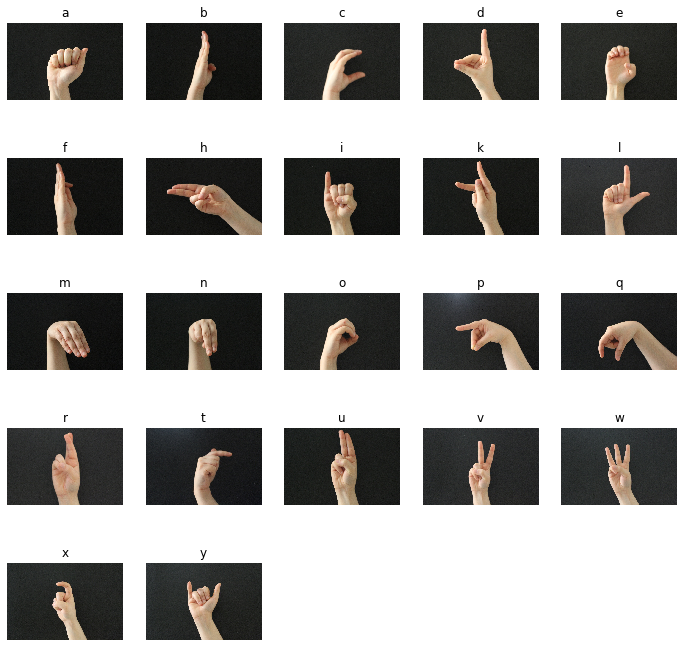

In [0]:
dataset = SignDataset(transform=transform, plot_images=True)

# check dataset size
print('Dataset size: {}'.format(len(dataset)))

Split the dataset

In [0]:
train_indexes = [idx for idx in range(len(dataset)) if idx % 5 and (idx+1) % 6]
validation_indexes = [idx for idx in range(len(dataset)) if not idx % 6]
test_indexes = [idx for idx in range(len(dataset)) if not (idx+1) % 6]
final_training_indexes = train_indexes + validation_indexes

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)
test_dataset = Subset(dataset, test_indexes)
final_dataset = Subset(dataset,final_training_indexes)

# check dataset sizes
print('Train Dataset:\t\t{}'.format(len(train_dataset)))
print('Validation Dataset:\t{}'.format(len(validation_dataset)))
print('Test Dataset:\t\t{}'.format(len(test_dataset)))
# final dataset (combination of training and validation) will be used for the final training
print('Final Dataset:\t\t{}'.format(len(final_dataset)))

Train Dataset:		4286
Validation Dataset:	1072
Test Dataset:		1071
Final Dataset:		5358


In [0]:
# dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
final_dataloader = train_dataloader = DataLoader(final_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

## Validation

**Default parameters**

In [0]:
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 20
STEP_SIZE = 100
GAMMA = 0.1
LR = 1e-3
alpha = 0.8

**Utility functions**

In [0]:
# loss claculation according to DeepPose paper
def CustomMSELoss(output, target):
    dummy_tensor = (torch.tensor([0,0]).repeat(target.size()[1],1)).repeat(target.size()[0],1,1).cuda()
    
    visibility_x = torch.eq(target[:,:,0], dummy_tensor[:,:,0])
    visibility_y = torch.eq(target[:,:,1], dummy_tensor[:,:,1])
    visibility = ~(visibility_x*visibility_y)
   
    del dummy_tensor
    diff = output - target
    
    square_x=(visibility*diff[:,:,0])**2
    square_y=(visibility*diff[:,:,1])**2
   
    square_x/=(target.size()[0])
    square_y/=(target.size()[0])
    
    loss = torch.sum(square_x+square_y) 
    return loss

In [0]:
def modelInitialization(wrist_avg,lr=LR,momentum=MOMENTUM,weight_decay=WEIGHT_DECAY,step_size=STEP_SIZE,gamma=GAMMA):
    net = Joints2Sign(wrist_avg)
    
    classification_criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    net = net.to(DEVICE)
    return net,scheduler,optimizer,classification_criterion

### With static weights

In [0]:
def train(net,scheduler,optimizer,classification_criterion,train_dataloader,val_dataloader,alpha,num_epochs=5,reg=WEIGHT_DECAY):
  # start iterating over the epochs
  for epoch in range(num_epochs):
     
      n_batches=0
      total_loss=0
      total_loss_joints=0
      total_loss_label=0
      for images, labels, joints in train_dataloader:
          n_batches+=1
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)
          joints = joints.to(DEVICE)

          net.train(True)
          optimizer.zero_grad()

          # forward pass to the network
          predicted_joints, predicted_labels = net(images)

          # compute loss based on output and ground truth
          loss_joints = CustomMSELoss(predicted_joints, joints)
          loss_label = classification_criterion(predicted_labels, labels)
          loss = loss_joints * alpha + loss_label * (1 - alpha)
          total_loss_joints+=loss_joints
          total_loss_label+=loss_label
          total_loss+=loss
          loss.backward() 
          
          optimizer.step() # update weights based on accumulated gradients
          
          del images
          del labels
          del joints
          
      if (torch.isnan(total_loss)):
        print("NaN: break ")
        break
      print('\nEpoch {}/{}, LR= {}, alpha {}, reg {}:'.format(epoch+1, num_epochs, scheduler.get_lr(), alpha, reg))
      print('\tTRAINING: Regression Loss: {} , Classification Loss: {}, Total Loss: {}'.format(total_loss_joints.item()/n_batches,total_loss_label.item()/n_batches,total_loss.item()/n_batches))
      
      n_batches=0
      total_loss=0
      total_loss_joints=0
      total_loss_label=0
      for images, labels, joints in val_dataloader:
          n_batches+=1
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)
          joints = joints.to(DEVICE)

          net.train(False)
          # forward pass to the network
          predicted_joints, predicted_labels = net(images)
          # compute loss based on output and ground truth
          loss_joints = CustomMSELoss(predicted_joints, joints)
          loss_label = classification_criterion(predicted_labels, labels)
          loss = loss_joints * alpha + loss_label * (1 - alpha)

          total_loss+=loss
          total_loss_joints+=loss_joints
          total_loss_label+=loss_label
          del images
          del labels
          del joints
    
      print('\tVALIDATION: Regression Loss: {} , Classification Loss: {}, Total Loss: {}'.format(total_loss_joints.item()/n_batches,total_loss_label.item()/n_batches,total_loss.item()/n_batches))
      
      # step the scheduler
      scheduler.step() 

In [0]:
def coarse_fine_validation(reg_min,reg_max,lr_min,lr_max, alphaList,count=100,num_epochs=5):
  for c in range(count):
    reg = 10**np.random.uniform(reg_min,reg_max)
    lr  = 10**np.random.uniform(lr_min,lr_max)
    alpha = random.choice(alphaList)
    print('Count = {}'.format(c))
    net,scheduler,optimizer,classification_criterion = modelInitialization(wrist_avg,lr,weight_decay=reg)
    train(net,scheduler,optimizer,classification_criterion,train_dataloader,validation_dataloader,alpha,num_epochs,reg)
    del net

In [0]:
def grid_validation(lr_list, alpha, reg, num_epochs=5):
   for lr in lr_list:
     net,scheduler,optimizer,classification_criterion = modelInitialization(wrist_avg,lr,weight_decay=reg)
     train(net,scheduler,optimizer,classification_criterion,train_dataloader,validation_dataloader,alpha,num_epochs,reg)
     del net

In [0]:
# train while storing losses, to display them later on
def trainLoss(net,optimizer,scheduler,classification_criterion,train_dataloader,val_dataloader,alpha,num_epochs=5,reg=WEIGHT_DECAY,step_size=50):
  
  t_loss_joints = []
  t_loss_label = []
  v_loss_joints = []
  v_loss_label = []
  t_tot = []
  v_tot = []
  for epoch in range(num_epochs):
      
      n_batches=0
      total_loss=0
      total_loss_joints=0
      total_loss_label=0
      for images, labels, joints in train_dataloader:
          n_batches+=1
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)
          joints = joints.to(DEVICE)

          net.train(True)
          optimizer.zero_grad() 

          # forward pass to the network
          predicted_joints, predicted_labels = net(images)
        
          # compute loss based on output and ground truth
          loss_joints = CustomMSELoss(predicted_joints, joints)
          loss_label = classification_criterion(predicted_labels, labels)
          loss = loss_joints * alpha + loss_label * (1 - alpha)
          total_loss_joints+=loss_joints
          total_loss_label+=loss_label
          total_loss+=loss
          loss.backward() 

          optimizer.step() # update weights based on accumulated gradients
       
          del images
          del labels
          del joints
          
      t_loss_joints.append(total_loss_joints.item()/n_batches)
      t_loss_label.append(total_loss_label.item()/n_batches)
      t_tot.append(total_loss.item()/n_batches)
      print('\nEpoch {}/{}, LR= {}, alpha {}, reg {}:'.format(epoch+1, num_epochs, scheduler.get_lr(), alpha, reg))
      print('\tTRAINING:\tRegression Loss: {} , Classification Loss: {}, Total Loss: {}'.format(total_loss_joints.item()/n_batches,total_loss_label.item()/n_batches,total_loss.item()/n_batches))
     
      n_batches=0
      total_loss=0
      total_loss_joints=0
      total_loss_label=0
      for images, labels, joints in val_dataloader:
          n_batches+=1
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)
          joints = joints.to(DEVICE)

          net.train(False)
          # forward pass to the network
          predicted_joints, predicted_labels = net(images)
          
          # compute loss based on output and ground truth
          loss_joints = CustomMSELoss(predicted_joints, joints)
          loss_label = classification_criterion(predicted_labels, labels)
          loss = loss_joints * alpha + loss_label * (1 - alpha)

          total_loss+=loss
          total_loss_joints+=loss_joints
          total_loss_label+=loss_label
          del images
          del labels
          del joints
      v_loss_joints.append(total_loss_joints.item()/n_batches)
      v_loss_label.append(total_loss_label.item()/n_batches)
      v_tot.append(total_loss.item()/n_batches)
      print('\tVALIDATION:\tRegression Loss: {} , Classification Loss: {}, Total Loss: {}'.format(total_loss_joints.item()/n_batches,total_loss_label.item()/n_batches,total_loss.item()/n_batches))
      
      # step the scheduler
      scheduler.step() 
  return t_loss_joints,t_loss_label,v_loss_joints,v_loss_label,t_tot,v_tot


Epoch 1/150, LR= [0.01], alpha 0.5, reg 5e-05:
	TRAINING:	Regression Loss: 6.276889223040956 , Classification Loss: 3.0918414953983193, Total Loss: 4.684365937204072
	VALIDATION:	Regression Loss: 1.9207184314727783 , Classification Loss: 3.0947606563568115, Total Loss: 2.507739543914795

Epoch 2/150, LR= [0.01], alpha 0.5, reg 5e-05:
	TRAINING:	Regression Loss: 1.808854998964252 , Classification Loss: 3.087117744214607, Total Loss: 2.447986024798769
	VALIDATION:	Regression Loss: 1.6780166625976562 , Classification Loss: 3.091003894805908, Total Loss: 2.3845102787017822

Epoch 3/150, LR= [0.01], alpha 0.5, reg 5e-05:
	TRAINING:	Regression Loss: 1.7525692564068418 , Classification Loss: 3.0877766464695786, Total Loss: 2.4201729514382104
	VALIDATION:	Regression Loss: 1.5499457120895386 , Classification Loss: 3.107173204421997, Total Loss: 2.328559637069702

Epoch 4/150, LR= [0.01], alpha 0.5, reg 5e-05:
	TRAINING:	Regression Loss: 1.2787253639914773 , Classification Loss: 3.1020979447798

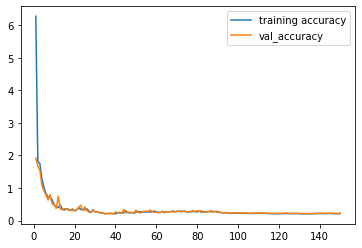

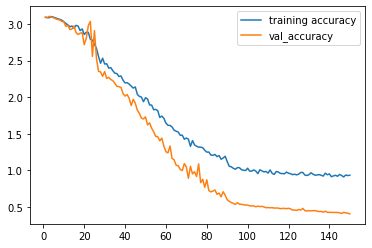

In [0]:
num_epochs = 150
alpha = 0.5
lr = 0.01
reg = 5e-5
step_size=90
net,scheduler,optimizer,classification_criterion = modelInitialization(wrist_avg,lr,weight_decay=reg,step_size=step_size)

t_loss_joints,t_loss_label,v_loss_joints,v_loss_label,t_tot,v_tot = trainLoss(net,optimizer,scheduler,classification_criterion,train_dataloader,validation_dataloader,alpha,num_epochs,reg=reg)
# torch.save(net.state_dict(), './static_model.pth')

# plot regression loss
plt.plot(range(1,num_epochs+1),t_loss_joints,label="training accuracy")
plt.plot(range(1,num_epochs+1),v_loss_joints,label="val_accuracy")
plt.xticks(np.arange(0, num_epochs+1, 20))
plt.legend()
plt.show()

# plot classification loss
plt.plot(range(1,num_epochs+1),t_loss_label,label="training accuracy")
plt.plot(range(1,num_epochs+1),v_loss_label,label="val_accuracy")
plt.xticks(np.arange(0, num_epochs+1, 20))
plt.legend()
plt.show()

### With dynamic weights

In [0]:
def train_loss_balanced(net,optimizer,scheduler,classification_criterion,train_dataloader,val_dataloader,alpha,num_epochs=5,reg=WEIGHT_DECAY,step_size=50):
    t_loss_joints = []
    t_loss_label = []
    v_loss_joints = []
    v_loss_label = []
    t_tot = []
    v_tot = []
    for epoch in range(num_epochs):
      
        n_batches=0
        total_loss=0
        total_loss_joints=0
        total_loss_label=0

        first_batch = True     
        for images, labels, joints in train_dataloader:
            n_batches+=1
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            joints = joints.to(DEVICE)

            net.train(True)
            optimizer.zero_grad()

            # forward pass to the network
            predicted_joints, predicted_labels = net(images)
            
            # compute loss based on output and ground truth
            loss_joints = CustomMSELoss(predicted_joints, joints)
            loss_label = classification_criterion(predicted_labels, labels)
            total_loss_joints+=loss_joints
            total_loss_label+=loss_label

            # compute gradients for each layer and update weights
            if first_batch == True:
                first_batch_loss_joints = loss_joints.item()
                first_batch_loss_label = loss_label.item()
                w_joints = w_label = 1
                first_batch = False
            else:
                w_joints = (loss_joints / first_batch_loss_joints)**alpha
                w_label = (loss_label / first_batch_loss_label)**alpha
            
            loss = loss_joints * w_joints + loss_label * w_label
            total_loss+=loss
            loss.backward() 
            
            optimizer.step() # update weights based on accumulated gradients
       
            del images
            del labels
            del joints              

        t_loss_joints.append(total_loss_joints.item()/n_batches)
        t_loss_label.append(total_loss_label.item()/n_batches)
        t_tot.append(total_loss.item()/n_batches)
        print('\nEpoch {}/{}, LR= {}, alpha {}, reg {}:'.format(epoch+1, num_epochs, scheduler.get_lr(), alpha, reg))
        print('\tTRAINING:\tRegression Loss: {} , Classification Loss: {}, Total Loss: {}'.format(total_loss_joints.item()/n_batches,total_loss_label.item()/n_batches,total_loss.item()/n_batches))
     
        n_batches=0
        total_loss=0
        total_loss_joints=0
        total_loss_label=0
        for images, labels, joints in val_dataloader:
            n_batches+=1
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            joints = joints.to(DEVICE)

            net.train(False)
            # forward pass to the network
            predicted_joints, predicted_labels = net(images)
            
            # compute loss based on output and ground truth
            loss_joints = CustomMSELoss(predicted_joints, joints)
            loss_label = classification_criterion(predicted_labels, labels)
            loss = loss_joints + loss_label

            total_loss+=loss
            total_loss_joints+=loss_joints
            total_loss_label+=loss_label
            del images
            del labels
            del joints
        v_loss_joints.append(total_loss_joints.item()/n_batches)
        v_loss_label.append(total_loss_label.item()/n_batches)
        v_tot.append(total_loss.item()/n_batches)
        print('\tVALIDATION:\tRegression Loss: {} , Classification Loss: {}, Total Loss: {}'.format(total_loss_joints.item()/n_batches,total_loss_label.item()/n_batches,total_loss.item()/n_batches))
        
        # step the scheduler
        scheduler.step() 
    return t_loss_joints,t_loss_label,v_loss_joints,v_loss_label,t_tot,v_tot


Epoch 1/150, LR= [0.005], alpha 0.5, reg 5e-05:
	TRAINING:	Regression Loss: 4.825871323094224 , Classification Loss: 3.095815947561553, Total Loss: 6.473275849313447
	VALIDATION:	Regression Loss: 1.9694104194641113 , Classification Loss: 3.0946784019470215, Total Loss: 5.064088821411133

Epoch 2/150, LR= [0.005], alpha 0.5, reg 5e-05:
	TRAINING:	Regression Loss: 1.8660556908809778 , Classification Loss: 3.0886255900065103, Total Loss: 4.787508877840909
	VALIDATION:	Regression Loss: 1.9074108600616455 , Classification Loss: 3.0942118167877197, Total Loss: 5.001622676849365

Epoch 3/150, LR= [0.005], alpha 0.5, reg 5e-05:
	TRAINING:	Regression Loss: 1.7287525986180161 , Classification Loss: 3.0787714177911933, Total Loss: 4.69008798310251
	VALIDATION:	Regression Loss: 1.864787220954895 , Classification Loss: 3.091578960418701, Total Loss: 4.956366062164307

Epoch 4/150, LR= [0.005], alpha 0.5, reg 5e-05:
	TRAINING:	Regression Loss: 1.8401477698123816 , Classification Loss: 3.06999391497

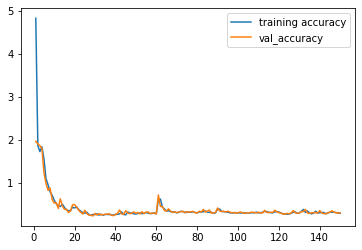

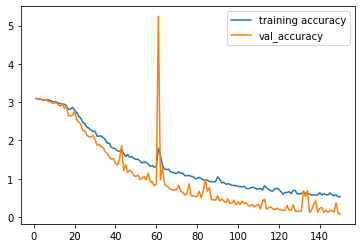

In [0]:
num_epochs = 150
alpha = 0.5
lr = 0.005
reg = 5e-5
step_size=200
torch.cuda.empty_cache()
net,scheduler,optimizer,classification_criterion = modelInitialization(wrist_avg,lr,weight_decay=reg,step_size=step_size)

t_loss_joints,t_loss_label,v_loss_joints,v_loss_label,t_tot,v_tot = train_loss_balanced(net,optimizer,scheduler,classification_criterion,train_dataloader,validation_dataloader,alpha,num_epochs,reg=reg)
# torch.save(net.state_dict(), './dynamic_model.pth')

# plot regression loss
plt.plot(range(1,num_epochs+1),t_loss_joints,label="training accuracy")
plt.plot(range(1,num_epochs+1),v_loss_joints,label="val_accuracy")
plt.xticks(np.arange(0, num_epochs+1, 20))
plt.legend()
plt.show()

# plot classification loss
plt.plot(range(1,num_epochs+1),t_loss_label,label="training accuracy")
plt.plot(range(1,num_epochs+1),v_loss_label,label="val_accuracy")
plt.xticks(np.arange(0, num_epochs+1, 20))
plt.legend()
plt.show()


## Training

### Train J2S Static

In [0]:
def train_static(net,optimizer,scheduler,classification_criterion,train_dataloader,alpha,num_epochs=5,reg=WEIGHT_DECAY,step_size=50):
  
  t_loss_joints = []
  t_loss_label = []
  t_tot = []
  for epoch in range(num_epochs):
      
      n_batches=0
      total_loss=0
      total_loss_joints=0
      total_loss_label=0
      for images, labels, joints in train_dataloader:
          n_batches+=1
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)
          joints = joints.to(DEVICE)

          net.train(True)
          optimizer.zero_grad()

          # forward pass to the network
          predicted_joints, predicted_labels = net(images)
        
          # compute loss based on output and ground truth
          loss_joints = CustomMSELoss(predicted_joints, joints)
          loss_label = classification_criterion(predicted_labels, labels)
          loss = loss_joints * alpha + loss_label * (1 - alpha)
          total_loss_joints+=loss_joints
          total_loss_label+=loss_label
          total_loss+=loss

          loss.backward() 
        
          optimizer.step() # update weights based on accumulated gradients
       
          del images
          del labels
          del joints      

      t_loss_joints.append(total_loss_joints.item()/n_batches)
      t_loss_label.append(total_loss_label.item()/n_batches)
      t_tot.append(total_loss.item()/n_batches)
      print('\nEpoch {}/{}, LR= {}, alpha {}, reg {}:'.format(epoch+1, num_epochs, scheduler.get_lr(), alpha, reg))
      print('\t\tRegression Loss: {} , Classification Loss: {}, Total Loss: {}'.format(total_loss_joints.item()/n_batches,total_loss_label.item()/n_batches,total_loss.item()/n_batches))
      # step the scheduler
      scheduler.step() 
  return t_tot


Epoch 1/150, LR= [0.01], alpha 0.5, reg 5e-05:
		Regression Loss: 5.388739236971227 , Classification Loss: 3.092316604242092, Total Loss: 4.240527641482469

Epoch 2/150, LR= [0.01], alpha 0.5, reg 5e-05:
		Regression Loss: 1.740666645329173 , Classification Loss: 3.0861617297661015, Total Loss: 2.4134143736304305

Epoch 3/150, LR= [0.01], alpha 0.5, reg 5e-05:
		Regression Loss: 1.3817315450528773 , Classification Loss: 3.0887858693192647, Total Loss: 2.2352585211032774

Epoch 4/150, LR= [0.01], alpha 0.5, reg 5e-05:
		Regression Loss: 0.9828701484494093 , Classification Loss: 3.0819287183808117, Total Loss: 2.032399247332317

Epoch 5/150, LR= [0.01], alpha 0.5, reg 5e-05:
		Regression Loss: 0.7545896390589272 , Classification Loss: 3.068514195884146, Total Loss: 1.9115513127024581

Epoch 6/150, LR= [0.01], alpha 0.5, reg 5e-05:
		Regression Loss: 0.612159310317621 , Classification Loss: 3.0554733276367188, Total Loss: 1.8338165283203125

Epoch 7/150, LR= [0.01], alpha 0.5, reg 5e-05:

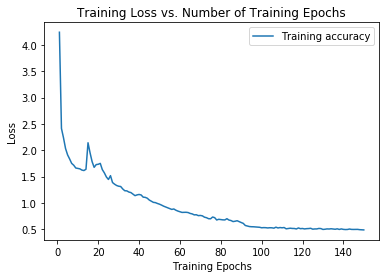

In [0]:
# STATIC: LR= [0.01], alpha 0.5, reg 5e-05, step size=90:
num_epochs = 150
alpha = 0.5
lr = 0.01
reg = 5e-5
step_size=90
net,scheduler,optimizer,classification_criterion = modelInitialization(wrist_avg,lr,weight_decay=reg,step_size=step_size)

t_tot = train_static(net,optimizer,scheduler,classification_criterion,final_dataloader,alpha,num_epochs,reg=reg)
#torch.save(net.state_dict(), './FinalStaticModel.pth')

# plot total loss
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),t_tot,label="Training accuracy")
plt.xticks(np.arange(0, num_epochs+1, 20))
plt.legend()
plt.show()

### Train J2S Dynamic

In [0]:
def train_dynamic(net,optimizer,scheduler,classification_criterion,train_dataloader,alpha,num_epochs=5,reg=WEIGHT_DECAY,step_size=50):
  
    t_loss_joints = []
    t_loss_label = []
    t_tot = []
    for epoch in range(num_epochs):
      
        n_batches=0tra
        total_loss=0
        total_loss_joints=0
        total_loss_label=0

        first_batch = True     
        for images, labels, joints in train_dataloader:
            n_batches+=1
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            joints = joints.to(DEVICE)

            net.train(True)
            optimizer.zero_grad()

            # forward pass to the network
            predicted_joints, predicted_labels = net(images)
            
            # compute loss based on output and ground truth
            loss_joints = CustomMSELoss(predicted_joints, joints)
            loss_label = classification_criterion(predicted_labels, labels)
            total_loss_joints+=loss_joints
            total_loss_label+=loss_label

            if first_batch == True:
                first_batch_loss_joints = loss_joints.item()
                first_batch_loss_label = loss_label.item()
                w_joints = w_label = 1
                first_batch = False
            else:
                w_joints = (loss_joints / first_batch_loss_joints)**alpha
                w_label = (loss_label / first_batch_loss_label)**alpha
            
            loss = loss_joints * w_joints + loss_label * w_label
            total_loss+=loss
            loss.backward() 
            
            optimizer.step() # update weights based on accumulated gradients
       
            del images
            del labels
            del joints 
        if (torch.isnan(total_loss)):
            print("NaN: break ")
            break             

        t_loss_joints.append(total_loss_joints.item()/n_batches)
        t_loss_label.append(total_loss_label.item()/n_batches)
        t_tot.append(total_loss.item()/n_batches)
        print('\nEpoch {}/{}, LR= {}, alpha {}, reg {}:'.format(epoch+1, num_epochs, scheduler.get_lr(), alpha, reg))
        print('\t\tRegression Loss: {} , Classification Loss: {}, Total Loss: {}'.format(total_loss_joints.item()/n_batches,total_loss_label.item()/n_batches,total_loss.item()/n_batches))
     
        # step the scheduler
        scheduler.step() 
    return t_tot

In [0]:
# DINAMIC: LR= [0.005], alpha 0.8, reg 5e-05, step size=90
num_epochs = 150
alpha = 0.8
lr = 0.005
reg = 5e-5
step_size= 90
torch.cuda.empty_cache()
net,scheduler,optimizer,classification_criterion = modelInitialization(wrist_avg,lr,weight_decay=reg,step_size=step_size)

t_tot = train_dynamic(net,optimizer,scheduler,classification_criterion,final_dataloader,alpha,num_epochs,reg=reg)
#torch.save(net.state_dict(), './FinalDynamicModel.pth')

# plot total loss
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),t_tot,label="Training accuracy")
plt.xticks(np.arange(0, num_epochs+1, 20))
plt.xticks(np.arange(0,4.0, 0.5))
plt.legend()
plt.show()


Epoch 1/150, LR= [0.005], alpha 0.8, reg 5e-05:
		Regression Loss: 4.099785037157012 , Classification Loss: 3.093567266696837, Total Loss: 5.308046294421684

Epoch 2/150, LR= [0.005], alpha 0.8, reg 5e-05:
		Regression Loss: 1.8397043739877097 , Classification Loss: 3.0814644418111663, Total Loss: 4.895737810832698

Epoch 3/150, LR= [0.005], alpha 0.8, reg 5e-05:
		Regression Loss: 1.5308635990794113 , Classification Loss: 3.080082590987043, Total Loss: 4.344693439762767

Epoch 4/150, LR= [0.005], alpha 0.8, reg 5e-05:
		Regression Loss: 1.1001585983648532 , Classification Loss: 3.0884529672017913, Total Loss: 4.036579039038681

Epoch 5/150, LR= [0.005], alpha 0.8, reg 5e-05:
		Regression Loss: 0.8250596581435785 , Classification Loss: 3.058372125393007, Total Loss: 3.772088027581936

Epoch 6/150, LR= [0.005], alpha 0.8, reg 5e-05:
		Regression Loss: 0.6593981021788062 , Classification Loss: 3.0273435639172064, Total Loss: 3.6469101324314024

Epoch 7/150, LR= [0.005], alpha 0.8, reg 5

### Train ISL

In [0]:
NUM_EPOCHS = 20
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [0]:
%%time
net = ISL()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-07, weight_decay=0, amsgrad=False)
net = net.to(DEVICE)

for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS))

    for images, labels, _ in train_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train(True)
        optimizer.zero_grad()
        predicted_labels = net(images)

        loss = criterion(predicted_labels, labels)
        loss.backward() 
        optimizer.step()
    print('Loss: {}'.format(loss.item()))

Starting epoch 1/20
Loss: 2.0521738529205322
Starting epoch 2/20
Loss: 1.229052186012268
Starting epoch 3/20
Loss: 1.141173243522644
Starting epoch 4/20
Loss: 0.45605581998825073
Starting epoch 5/20
Loss: 0.605460524559021
Starting epoch 6/20
Loss: 0.37799426913261414
Starting epoch 7/20
Loss: 0.48352259397506714
Starting epoch 8/20
Loss: 0.45009052753448486
Starting epoch 9/20
Loss: 0.15729117393493652
Starting epoch 10/20
Loss: 0.24896547198295593
Starting epoch 11/20
Loss: 0.2949393391609192
Starting epoch 12/20
Loss: 0.34470608830451965
Starting epoch 13/20
Loss: 0.22549018263816833
Starting epoch 14/20
Loss: 0.361120343208313
Starting epoch 15/20
Loss: 0.14868882298469543
Starting epoch 16/20
Loss: 0.4104060232639313
Starting epoch 17/20
Loss: 0.07466886937618256
Starting epoch 18/20
Loss: 0.20231691002845764
Starting epoch 19/20
Loss: 0.05921068787574768
Starting epoch 20/20
Loss: 0.08370310068130493
CPU times: user 39.8 s, sys: 30.4 s, total: 1min 10s
Wall time: 3min 30s


## Test

### Evaluation metrics

#### Confusion matrix

In [0]:
def plot_confusion_matrix(true, pred):
    matrix = confusion_matrix(true, pred)
    fig, ax = plt.subplots(figsize=(12,7))
    ax = sns.heatmap(matrix, cmap='Blues', annot=True)

    signs = dataset.labels.keys()
    ax.set_xticklabels(signs, rotation = 0, fontsize=13)
    ax.set_yticklabels(signs, rotation = 0, fontsize=13)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix', fontweight="bold")

#### Precision, recall, F1-score

In [0]:
def print_precision_recall_f1(true, pred):
    precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(true, pred, average='macro')
    print(f"Precision: {precision}\nRecall: {recall}\nF1-score: {f1_score}")

#### EPE, PCK and AUC

*EvalUtil* taken from https://github.com/lmb-freiburg/hand3d/blob/9f0063391e7075cf4ab1e4edd0461d38213a3fd6/utils/general.py

In [0]:
class EvalUtil:
    """ Util class for evaluation networks.
    """
    def __init__(self, num_kp=21):
        # init empty data storage
        self.data = list()
        self.num_kp = num_kp
        for _ in range(num_kp):
            self.data.append(list())

    def feed(self, keypoint_gt, keypoint_vis, keypoint_pred):
        """ Used to feed data to the class. Stores the euclidean distance between gt and pred, when it is visible. """
        keypoint_gt = np.squeeze(keypoint_gt)
        keypoint_pred = np.squeeze(keypoint_pred)
        keypoint_vis = np.squeeze(keypoint_vis).astype('bool')

        assert len(keypoint_gt.shape) == 2
        assert len(keypoint_pred.shape) == 2
        assert len(keypoint_vis.shape) == 1

        # calc euclidean distance
        diff = keypoint_gt - keypoint_pred
        euclidean_dist = np.sqrt(np.sum(np.square(diff), axis=1))

        num_kp = keypoint_gt.shape[0]
        for i in range(num_kp):
            if keypoint_vis[i]:
                self.data[i].append(euclidean_dist[i])

    def _get_pck(self, kp_id, threshold):
        """ Returns pck for one keypoint for the given threshold. """
        if len(self.data[kp_id]) == 0:
            return None

        data = np.array(self.data[kp_id])
        pck = np.mean((data <= threshold).astype('float'))
        return pck

    def _get_epe(self, kp_id):
        """ Returns end point error for one keypoint. """
        if len(self.data[kp_id]) == 0:
            return None, None

        data = np.array(self.data[kp_id])
        epe_mean = np.mean(data)
        epe_median = np.median(data)
        return epe_mean, epe_median

    def get_measures(self, val_min, val_max, steps):
        """ Outputs the average mean and median error as well as the pck score. """
        thresholds = np.linspace(val_min, val_max, steps)
        thresholds = np.array(thresholds)
        norm_factor = np.trapz(np.ones_like(thresholds), thresholds)

        # init mean measures
        epe_mean_all = list()
        epe_median_all = list()
        auc_all = list()
        pck_curve_all = list()

        # create one plot for each part
        for part_id in range(self.num_kp):
            # mean/median error
            mean, median = self._get_epe(part_id)

            if mean is None:
                # there was no valid measurement for this keypoint
                continue

            epe_mean_all.append(mean)
            epe_median_all.append(median)

            # pck/auc
            pck_curve = list()
            for t in thresholds:
                pck = self._get_pck(part_id, t)
                pck_curve.append(pck)

            pck_curve = np.array(pck_curve)
            pck_curve_all.append(pck_curve)
            auc = np.trapz(pck_curve, thresholds)
            auc /= norm_factor
            auc_all.append(auc)

        epe_mean_all = np.mean(np.array(epe_mean_all))
        epe_median_all = np.mean(np.array(epe_median_all))
        auc_all = np.mean(np.array(auc_all))
        pck_curve_all = np.mean(np.array(pck_curve_all), 0)  # mean only over keypoints

        return epe_mean_all, epe_median_all, auc_all, pck_curve_all, thresholds

def calc_auc(x, y):
    """ Given x and y values it calculates the approx. integral and normalizes it: area under curve"""
    integral = np.trapz(y, x)
    norm = np.trapz(np.ones_like(y), x)

    return integral / norm

In [0]:
def show_joint_metrics(util):
    mean, median, auc, pck_curve_all, threshs = util.get_measures(0.0, 30.0, 20)
    print('Evaluation results:')
    print('Average mean EPE: %.3f pixels' % mean)
    print('Average median EPE: %.3f pixels' % median)
    print('Area under curve: %.3f' % auc)

    auc = calc_auc(threshs, pck_curve_all)
    curve_list = []
    curve_list.append((threshs, pck_curve_all, 'Ours (AUC=%.3f)' % auc))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    for t, v, name in curve_list:
        ax.plot(t, v, label=name)
    ax.set_xlabel('threshold in mm')
    ax.set_ylabel('PCK')
    plt.legend(loc='lower right')
    plt.show()

### Test ISL

In [0]:
all_preds = []
all_labels = []
net = net.to(DEVICE)
net.train(False)

running_corrects = 0
for images, labels, _ in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    
    predicted_labels = net(images)
    _, preds = torch.max(predicted_labels.data, 1)

    running_corrects += torch.sum(preds == labels.data).data.item()

    # store data for covariance matrix calculation
    all_preds = np.hstack((all_preds, preds.cpu()))
    all_labels = np.hstack((all_labels, labels.data.cpu()))

# calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))
print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 17/17 [00:03<00:00,  4.81it/s]

Test Accuracy: 0.9906629318394025


### Test J2S

In [0]:
# use already trained model if available by overriding the variable PATH
PATH = ''
# PATH = 'FinalDynamicModel.pth'
if PATH:
    net = Joints2Sign(wrist_avg)
    net.load_state_dict(torch.load(PATH))

In [0]:
net = net.to(DEVICE)
net.train(False)

all_preds = []
all_labels = []
util = EvalUtil()
running_corrects = 0
for images, labels, joints in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    joints = joints.to(DEVICE)
    
    # 1. forward Pass
    predicted_joints, predicted_labels = net(images)

    # 2. store data for joint metrics computation 
    dummy_tensor = torch.tensor([0,0]).repeat(joints.size()[0],21,1).cuda()
    visibility_x = joints[:,:,0] == dummy_tensor[:,:,0]
    visibility_y = joints[:,:,1] == dummy_tensor[:,:,1]
    visibility = ~(visibility_x * visibility_y) # 21x1, each value = True if joint is visible, False otherwise

    # iterate over the batch
    for j, v, pj in zip(joints, visibility, predicted_joints):
        # j: 21x2, v: 21, pj: 21x2; convert tensors to numpy arrays
        j, v, pj = j.cpu().numpy(), v.cpu().numpy(), pj.cpu().detach().numpy()
        # Normalize each pair of coordinate in the joint arrays
        for i in range(j.shape[0]):
            j[i] = denormalize(j[i])
            pj[i] = denormalize(pj[i])
        util.feed(j, v, pj)

    # 3. get predictions
    _, preds = torch.max(predicted_labels.data, 1)
    # update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

    # 4. store data for label metrics calculation
    all_preds = np.hstack((all_preds, preds.cpu()))
    all_labels = np.hstack((all_labels, labels.data.cpu()))

# calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))
print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 9/9 [00:04<00:00,  2.63it/s]

Test Accuracy: 0.996265172735761


Precision: 0.9961980300800053
Recall: 0.9961251167133521
F1-score: 0.9961227454153999


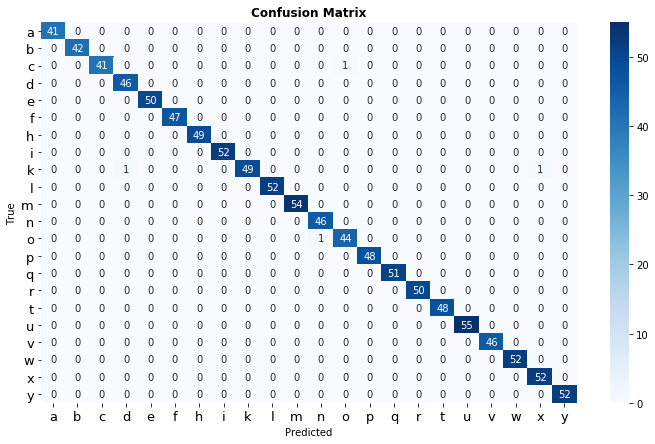

In [0]:
plot_confusion_matrix(all_labels,all_preds)
print_precision_recall_f1(all_labels, all_preds)

Evaluation results:
Average mean EPE: 21.817 pixels
Average median EPE: 17.149 pixels
Area under curve: 0.419


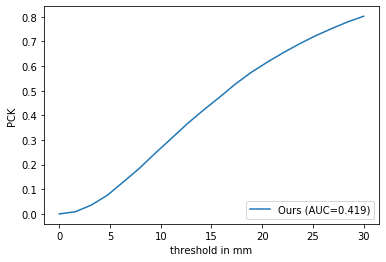

In [0]:
show_joint_metrics(util)

**Plot joints over image (red=J2S, blue=OpenPose)**

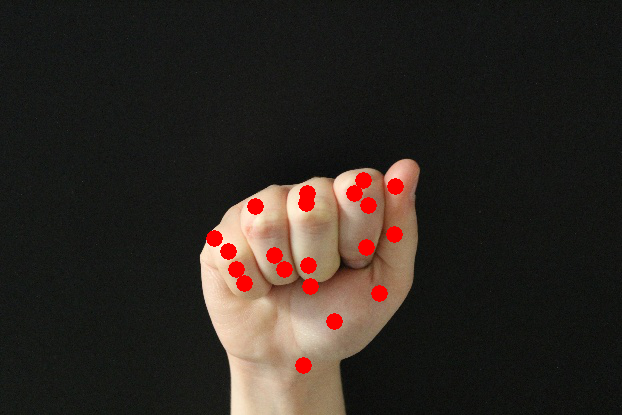

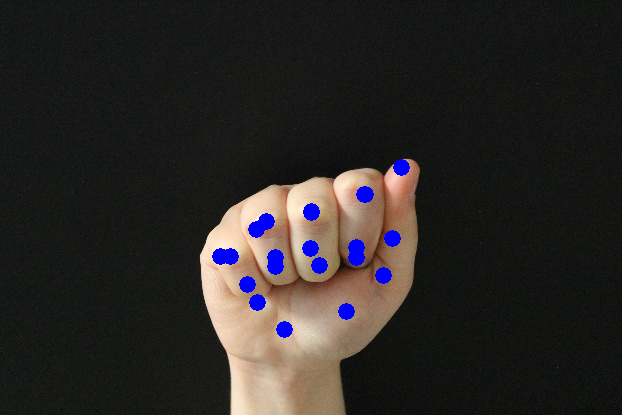

In [0]:
# index of the image to retrieve, change this to plot different images
img_id = 0

images,labels,joints = next(iter(test_dataloader))
net.train(False)
joints_out, _ = net(images.to(DEVICE))

images, _, _ = next(iter(test_dataloader_unnormalized))
open_cv_image = np.array(images[img_id])
open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2BGR)
openpose = copy(open_cv_image)

for point in joints_out[img_id].tolist():
    point = denormalize(point).astype(int).tolist()
    cv2.circle(open_cv_image, tuple(point), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
cv2_imshow(open_cv_image)

for point in joints[img_id].tolist():
    point = denormalize(point).astype(int).tolist()
    cv2.circle(openpose, tuple(point), 8, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
cv2_imshow(openpose)

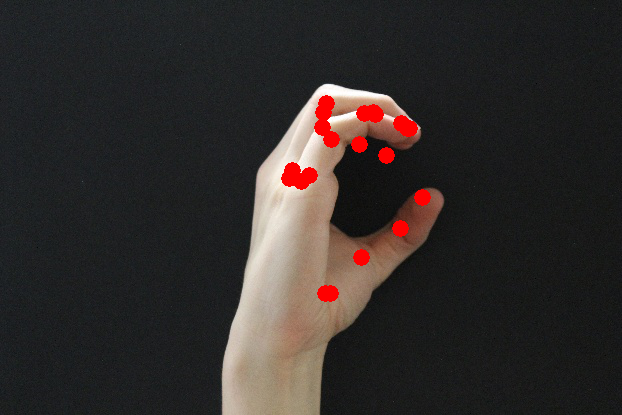

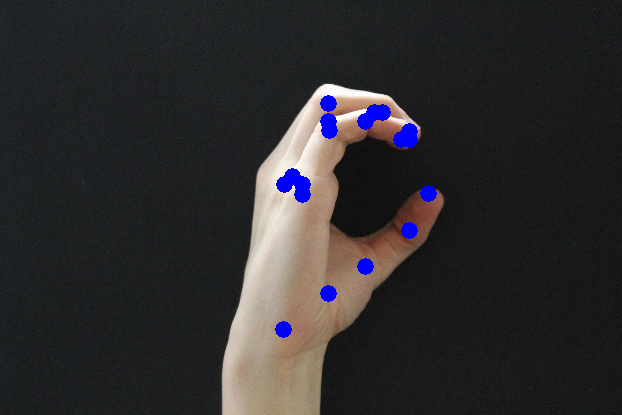

In [0]:
# as before, but plotting a different hand image
img_id = 100

images,labels,joints = next(iter(test_dataloader))
net.train(False)
joints_out, _ = net(images.to(DEVICE))

images, _, _ = next(iter(test_dataloader_unnormalized))
open_cv_image = np.array(images[img_id])
open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2BGR)
openpose = copy(open_cv_image)

for point in joints_out[img_id].tolist():
    point = denormalize(point).astype(int).tolist()
    cv2.circle(open_cv_image, tuple(point), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
cv2_imshow(open_cv_image)

for point in joints[img_id].tolist():
    point = denormalize(point).astype(int).tolist()
    cv2.circle(openpose, tuple(point), 8, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
cv2_imshow(openpose)